# TODO
- something that looks like solway figure!
- with all planning algorithms !!

- writing, solway, subway, experiment??

- 1. option learning for the graphs
- : do 2-option diagonal one, 1-option pair grids, 3-option hanoi

In [810]:
from ipypb import track as tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
import diffplan
import astar
import envs
import prior_envs
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1047]:
# ????
# HACK need more options than goals! otherwise you burn your options trying to learn goals...
import copy
env = copy.copy(prior_envs.f2d)

D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)

env.goal_set = set(env.states_features)
env.start_states = env.states
#env.goal_set = {5, 6, 7, 8, 9}
#env.start_states = [0, 1, 2, 3, 4]
#env2goal.goal_set = {(5, 11), (5, 9), (1, 6), (3, 11)}
#env2goal.goal_set = {(5, 11), (5, 9)}
#c = torch.tensor(D + BFS).float()
c = (D + BFS).float()# * 1.5
# HACK will add_goal_options add literally them to every xx?
#terms = torch.zeros((2, len(env.states)))
#terms[0, 4] = 5.
#terms[1, 5] = 5.
d=diffplan.option_learner(env, reset=200, search_cost=c, progress=20, grad_steps=400, lr=0.05, num_options=1, goal_uniform_random=True, plot=False, add_goal_options=True, term_max=1.)


seed 938728428
19 12.20987606048584
39 12.15178108215332
59 12.089923858642578
79 12.033726692199707
99 11.919544219970703
119 11.909673690795898
139 11.908333778381348
159 11.907817840576172
179 11.907503128051758
199 11.907276153564453
199 Reset optimizer state
219 11.906232833862305
239 11.906082153320312
259 11.906045913696289
279 11.906028747558594
299 11.90601921081543
319 11.906012535095215
339 11.906007766723633
359 11.906004905700684
379 11.90600299835205
399 11.906001091003418
399 Reset optimizer state


In [1048]:
eta = d[0].softmax(1)
for o in range(eta.shape[0]):
    print(o, sorted([(round(p.item(), 2), idx) for idx, p in enumerate(eta[o]) if p > 1e-2])[::-1])

0 [(1.0, 16)]


In [1049]:
#g = torch.zeros((1, len(env.states)))
#g[0, list(env.goal_set)[0]] = 100.
#diffplan.option_planner_bfs_vec(env, torch.cat((d[0], g)), (D + BFS).float())[0]

In [1052]:
# HACK HACK
#c = (D + BFS).float() #* 1.5

#for o in env.states:
#for os in [(4, 4), (4, 5), (3, 6), (6,7), (6,8),(3,9)]:#, (5, 5), (3, 4), (2, 3), (3, 5)]:
for os in env.states:#[16,10,9,2,8]:
    os = os if isinstance(os, (tuple,list)) else [os]
    vsum = 0
    for g in env.states:
        env.goal_set={g}
        terms = torch.zeros((1+len(os), len(env.states)))
        terms[0, g] = 100.
        for o, oval in enumerate(os):
            terms[o, oval] = 100.
        r = diffplan.option_planner_bfs_vec(env, terms, c)
        vsum += r[0].item()
    print(os, vsum/len(env.states))

[0] 19.99579530013235
[1] 18.026524342988665
[2] 16.95477385269968
[3] 20.617899192006963
[4] 18.97289155658923
[5] 17.951680835924652
[6] 19.99579560129266
[7] 18.026524844922516
[8] 16.954774103666608
[9] 15.807965153142026
[10] 16.954774204053376
[11] 18.02652564801668
[12] 19.99579570167943
[13] 17.951682040565892
[14] 18.97289286161724
[15] 20.617900195874665
[16] 16.954774455020303
[17] 18.02652564801668
[18] 19.99579560129266


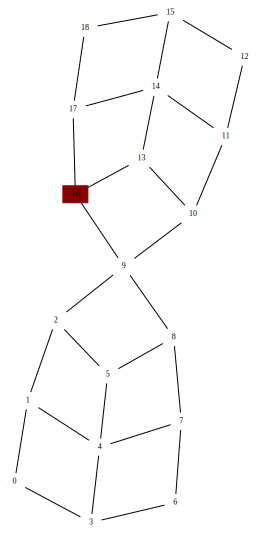

In [1010]:
#diffplan.plot_graph(env, alphas=d[0][0].softmax(0),labels=[str(x) for x in env.states_features])
diffplan.plot_graph(env, eta=d[0].softmax(1),labels=[str(x) for x in env.states_features])
#diffplan.plot_graph(env, alphas=d[0][0].softmax(0))

# dists

In [608]:
env = f2f
D = diffplan.compute_distance_matrix(env)

BFS = diffplan.compute_bfs_matrix(env, D)

BFS_full = D + BFS

rw = diffplan.compute_random_walk_search_cost(env)

samples = 100

DFS_distance, DFS = diffplan.compute_dfs_matrix(env, samples=samples, tqdm=tqdm)
DFS_full = DFS_distance + DFS

heuristic_cost_estimate = np.zeros((len(env.states), len(env.states)))
a_star_distance, a_star_cost = astar.compute_astar_matrix(env, heuristic_cost_estimate, samples=samples, tqdm=tqdm)
a_star_total = a_star_distance + a_star_cost

 [████████████████████████████████████████████████████████████] 27/27 [00:33<00:01, 1.21s/it]

 [████████████████████████████████████████████████████████████] 27/27 [00:18<00:01, 0.68s/it]

In [543]:
for cost_name in ['D', 'DFS', 'DFS_full', 'a_star_distance', 'a_star_cost', 'a_star_total']:
    c = locals()[cost_name]
    costs = torch.zeros(len(env.states))
    for source, dests in [(0, torch.LongTensor([1, 4]))]:
        print(cost_name, c[source, dests])


D tensor([1., 2.])
DFS tensor([6.5200, 3.3100])
DFS_full tensor([7.5200, 5.3100])
a_star_distance tensor([1., 2.])
a_star_cost tensor([2.8500, 5.0000])
a_star_total tensor([3.8500, 7.0000])


In [545]:
lefts = torch.LongTensor([0, 1, 2, 3])
rights = torch.LongTensor([6, 7, 8, 9])

#c = BFS
#c = rw
#c = DFS
c = a_star_cost

#for cost_name in ['BFS', 'BFS_full', 'DFS', 'DFS_full', 'rw', 'a_star_cost', 'a_star_total']:
for cost_name in ['BFS', 'DFS', 'a_star_cost', 'rw', 'BFS_full', 'DFS_full', 'a_star_total']:
    c = locals()[cost_name]
    costs = torch.zeros(len(env.states))
    #for sources, dests in [(lefts, rights), (rights, lefts)]:
    d = 0
    for sources, dests in [(lefts, rights), (rights, lefts)]:
        for dest in dests:
            costs += c[sources].mean(0) + c[:, dest]
            d += 1
    print(cost_name, [round(x, 2) for x in (costs/d).numpy()])

BFS [11.0, 10.5, 11.0, 10.5, 10.75, 10.75, 10.5, 11.0, 10.5, 11.0]
DFS [12.1, 11.42, 12.14, 11.4, 10.08, 10.27, 11.48, 12.04, 11.28, 11.84]
a_star_cost [11.47, 11.19, 11.52, 11.19, 11.17, 11.11, 11.2, 11.44, 11.19, 11.54]
rw [48.13, 45.63, 48.13, 45.63, 38.13, 38.13, 45.63, 48.13, 45.63, 48.13]
BFS_full [16.25, 15.0, 16.25, 15.0, 14.75, 14.75, 15.0, 16.25, 15.0, 16.25]
DFS_full [17.36, 15.92, 17.38, 15.9, 14.08, 14.27, 15.98, 17.29, 15.78, 17.09]
a_star_total [16.72, 15.69, 16.77, 15.69, 15.17, 15.11, 15.7, 16.69, 15.69, 16.79]


In [789]:
env = f2f
D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
BFS_full = D + .5*BFS # was wondering if weight on BFS might change this...

[((), ('B',), ('C', 'A')), (('B',), ('C', 'A'), ())]
tensor([23.0000, 21.0000, 16.5000, 17.5000, 17.0000, 17.0000, 21.0000, 24.0000,
        21.0000, 17.5000, 18.0000, 19.5000, 20.5000, 20.0000, 19.0000, 20.5000,
        20.5000, 22.5000, 16.5000, 17.5000, 18.5000, 18.5000, 25.5000, 18.0000,
        18.0000, 25.0000, 26.5000])
tensor([0.6500, 0.4500, 0.0000, 0.1000, 0.0500, 0.0500, 0.4500, 0.7500, 0.4500,
        0.1000, 0.1500, 0.3000, 0.4000, 0.3500, 0.2500, 0.4000, 0.4000, 0.6000,
        0.0000, 0.1000, 0.2000, 0.2000, 0.9000, 0.1500, 0.1500, 0.8500, 1.0000])


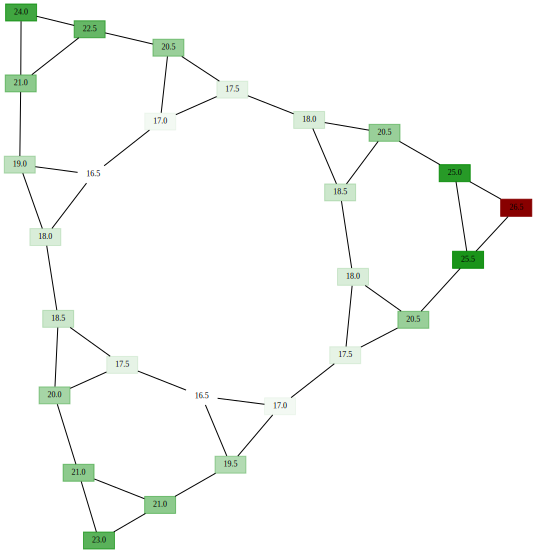

In [790]:
s = env.states_to_idx[(('B', 'A'),(),('C',))]
g = env.states_to_idx[(('C', 'A'),(),('B',))] # from the paper!
#g = env.states_to_idx[(('C', 'B'), ('A',), ())] # a potential study problem?

#s = env.states_to_idx[((), ('C', 'B'),('A',))]
#g = env.states_to_idx[(('C', 'B'),('A',), ())]

c = BFS_full[s, :] + BFS_full[:, g]
print([env.states_features[i] for i in np.where(c==c.min())[0]])
print(c)
a = c - c.min()
a /= a.max()
print(a)
diffplan.plot_graph(
    env, alphas=a,
    labels=[str(x.item()) for x in c],
#    labels=True,
)

In [781]:
def state_match_count(a, b):
    '''
    >>> assert state_match_count((('A', 'B', 'C'),()), (('A', 'B', 'C'),())) == 3
    >>> assert state_match_count((('A', 'B'), (), ('C',)), (('A',), ('C', 'B'), ())) == 1
    >>> assert state_match_count((('A', 'B', 'C'),()), (('C', 'B', 'A'),())) == 0
    '''
    same = 0
    for ca, cb in zip(a, b):
        for ita, itb in zip(ca, cb):
            if ita != itb:
                break
            same += 1
    return same

def compute_state_edit_distance(env):
    # HACK consider height limits?
    assert not env.canonicalize
    d = torch.zeros((len(env.states), len(env.states)))
    for s in tqdm(env.states):
        for g in env.states:
            d[s, g] = env.num_blocks - state_match_count(env.states_features[s], env.states_features[g])
    return d

b = envs.Blocks(2, canonicalize=False, hanoi=True)
print(b.states_features)
compute_state_edit_distance(b)

[((), (), ('B', 'A')), ((), ('A',), ('B',)), ((), ('B',), ('A',)), ((), ('B', 'A'), ()), (('A',), (), ('B',)), (('B',), (), ('A',)), (('A',), ('B',), ()), (('B',), ('A',), ()), (('B', 'A'), (), ())]


 [████████████████████████████████████████████████████████████] 9/9 [00:00<00:00, 0.00s/it]

tensor([[0., 1., 2., 2., 1., 2., 2., 2., 2.],
        [1., 0., 2., 2., 1., 2., 2., 1., 2.],
        [2., 2., 0., 1., 2., 1., 1., 2., 2.],
        [2., 2., 1., 0., 2., 2., 1., 2., 2.],
        [1., 1., 2., 2., 0., 2., 1., 2., 2.],
        [2., 2., 1., 2., 2., 0., 2., 1., 1.],
        [2., 2., 1., 1., 1., 2., 0., 2., 2.],
        [2., 1., 2., 2., 2., 1., 2., 0., 1.],
        [2., 2., 2., 2., 2., 1., 2., 1., 0.]])

In [808]:
# HACK trying to find good options with suboptimal paths... seems like there aren't any for 3/4 blocks
# HACK HACK HACK
# HACK HACK HACK
we actually want to find places where xxxxxx
# HACK HACK HACK

env = diffplan.Grid('''
x   x   xx
x       xx
x   x   xx
x xxxxx xx
x   x   xx
x   x   xx
xSxxxGxxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x     xxxx
''')

#heuristic_cost_estimate = astar.compute_manhattan_heuristic(env)
#a_dist, a_cost = astar.compute_astar_matrix(env, heuristic_cost_estimate, tqdm=tqdm)[1]
#xx_cost = a_dist + a_cost
        


env = envs.Blocks(3, canonicalize=False, height_limits=(3,3,3)) # 80s for 5, canonicalize=True
print(len(env.states))

%time D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
xx_cost = (D + BFS)

#heuristic_cost_estimate = compute_state_edit_distance(env)
#D, a_cost = astar.compute_astar_matrix(env, heuristic_cost_estimate, tqdm=tqdm, samples=10)
#xx_cost = D + a_cost

#xxxxxx ? A*? RW ?
for s in env.states:
    for g in env.states:
        c = xx_cost[s, :] + xx_cost[:, g]
        opts = np.where(c==c.min())[0]
        # For all good options, is there any where the cost is not the optimal?
        for o in opts:
            if D[s, o] + D[o, g] > D[s, g]:
                print(D[s, o] + D[o, g], D[s, g], env.states_features[s], env.states_features[o], env.states_features[g])

60
CPU times: user 898 ms, sys: 5.53 ms, total: 903 ms
Wall time: 930 ms
